In [1]:
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table
from astropy.table import Column

import spectrum
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os

In [2]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

This is the new version of the notbook for spectrophotometry, it runs all tasks 
(extraction of IFU stars, computation of the calibration and testing)
in one.


In [3]:
def extract(c, xc, yc, size, XX, YY, apfactor=2.):
    ww = c.grid()
    ss = np.zeros_like(ww)
    
    dd2 = np.sqrt( (XX-xc)**2. + (YY-yc)**2. )
    mask = dd2 <= apfactor * size
    for i,w in enumerate(ww):
        ss[i] = np.sum( c.data[i][mask] )
    return ww,ss

In [4]:
def extract_with_adm(c, adm, XX, YY, apfactor=2.):
    ww = c.grid()
    ss = np.zeros_like(ww)
    for i,w in enumerate(ww):
        xc = adm.xofw(w)
        yc = adm.yofw(w)
        size = adm.sofw(w)
        dd2 = np.sqrt( (XX-xc)**2. + (YY-yc)**2. )
        mask = dd2 <= apfactor * size
        ss[i] = np.sum( c.data[i][mask] )
    return ww,ss

In [5]:
def project(c,t):
    # project ra/dec from ifu star list to x,y
    ii = t['col1'] < 0.
    xx = []
    yy = []
    for i,r in enumerate(t):
        id,ra,dec = r["col2"], r["col3"], r["col4"]
        cos_term = np.cos(np.deg2rad(dec))
        w = wcs.WCS(c.hdu.header)
        #w.dropaxis(2)
        x,y,w = w.wcs_world2pix(ra,dec,5000.,0)

        shape = c.data.shape
        xx.append(x)
        yy.append(y)
        #if r['col2'] == 1237651753997238489:
        #    print(r['col2'], x,y, shape[2], shape[1])
        if x >= 0 and x <= shape[2] \
            and y >= 0 and y <= shape[1]:
                #print(x,y,w)
                ii[i] = True
                #print(True)

    t.add_column(Column(data=xx, name="x"))
    t.add_column(Column(data=yy, name="y"))
    return t[ii]


In [6]:
def atm_disp(c, x_com, y_com, size, XX, YY, dlambda=50.):
    wlgrid = c.grid()
    
    wlbins = np.arange(wlgrid[0], wlgrid[-1], dlambda)
    #print(wlbins)
    
    dd2 = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. ) 
    
    kk = dd2 <= 2. * size
    
    centroids = []
    for i in range(len(wlbins)-1):
        
        ll = wlgrid > wlbins[i] 
        ll *= wlgrid <= wlbins[i+1] 
        sl = np.nanmean( c.data[ll], axis=0 )
        

        M = np.sum(sl[kk])
        x_com = np.sum(sl[kk]*XX[kk])/M
        y_com = np.sum(sl[kk]*YY[kk])/M
        
        
        dx = np.sqrt( np.sum( sl[kk] * (XX[kk] - x_com)**2. ) / M ) * 2.35 # FWHM
        dy = np.sqrt( np.sum( sl[kk] * (YY[kk] - y_com)**2. ) / M ) * 2.35 # FWHM
        size = np.sqrt(dx**2. + dy**2.)
        flux = np.nansum(sl[kk])
        

        cwl = (wlbins[i] + wlbins[i+1] )/2.
        #print(cwl, x_com, y_com)
        centroids.append([cwl, flux, x_com, y_com, dx, dy, size])
        
    centroids = np.array(centroids) 

    
    return centroids
    #m = np.nanmean( c.data[500:550] , axis=0)
    #im[~kk] = 0
    #plt.imshow(im, origin='bottom')
    

In [7]:
class atm_disp_model:
    def __init__(self, centroids):
        self.centroids = centroids
        ii = ~np.isnan(centroids[:,2])
        self.pxdlambda = np.polyfit(centroids[ii,0],centroids[ii,2],deg=3)
        
        ii = ~np.isnan(centroids[:,3])
        self.pydlambda = np.polyfit(centroids[ii,0],centroids[ii,3],deg=3)
        
        ii = ~np.isnan(centroids[:,4])
        self.psxdlambda = np.polyfit(centroids[ii,0],centroids[ii,4],deg=3)
        
        ii = ~np.isnan(centroids[:,5])
        self.psydlambda = np.polyfit(centroids[ii,0],centroids[ii,5],deg=3)
        
        ii = ~np.isnan(centroids[:,6])
        self.psdlambda = np.polyfit(centroids[ii,0],centroids[ii,6],deg=3) 
    
    def xofw(self,wl):
        return np.polyval(self.pxdlambda, wl)
    
    def yofw(self,wl):
        return np.polyval(self.pydlambda, wl)
    
    def sxofw(self,wl):
        return np.polyval(self.psxdlambda, wl)
    
    def syofw(self,wl):
        return np.polyval(self.psydlambda, wl)
    
    def sofw(self,wl):
        return np.polyval(self.psdlambda, wl)
    
    
def model_atm_disp(centroids):
    adm = atm_disp_model(centroids)
    return adm

In [8]:
def plot(ifu, id, x, y, x_com, y_com, c, adm, ww,ss):
    f = plt.figure(figsize=[15,10])
    plt.subplot(2,4,1)
    plt.plot(adm.centroids[:,0], adm.centroids[:,2],'.')
    plt.plot(adm.centroids[:,0], adm.xofw(adm.centroids[:,0]),'b-')
    plt.xlabel("wl[A]")
    plt.ylabel("y [px]")
    
    plt.subplot(2,4,5)
    plt.plot(adm.centroids[:,0], adm.centroids[:,3],'.-')
    plt.plot(adm.centroids[:,0], adm.yofw(adm.centroids[:,0]),'b-')
    plt.xlabel("wl[A]")
    plt.ylabel("y [px]")
    
    plt.subplot(2,4,2)
    plt.plot(adm.centroids[:,0], adm.centroids[:,4],'.-')
    plt.xlabel("wl[A]")
    plt.ylabel("dx [px]")
    
    plt.subplot(2,4,6)
    plt.plot(adm.centroids[:,0], adm.centroids[:,5],'.-')
    plt.xlabel("wl[A]")
    plt.ylabel("dy [px]")
    
    plt.subplot(2,4,3)
    plt.plot(adm.centroids[:,0], adm.centroids[:,6],'.-')
    plt.plot(adm.centroids[:,0], adm.sofw(adm.centroids[:,0]),'b-')
    plt.xlabel("wl[A]")
    plt.ylabel("sqrt(dx^2 + dy^2) [px]")
    
    plt.subplot(2,4,7)
    plt.plot(adm.centroids[:,0], adm.centroids[:,1],'.')
    plt.xlabel("wl[A]")
    plt.ylabel("mean counts")
    
    w = wcs.WCS(c.hdu.header)
    w = w.dropaxis(2)

    ax1 = plt.subplot(2,4,4, projection=w)
    mm = np.nanmedian( c.data, axis = 0 )
    mm[mm == 0.] = np.nan
    plt.imshow(mm, origin='bottom')
    plt.plot(x,y,'x', c='white')
    plt.plot(x_com, y_com, 'x', c='red')

    ax2 = plt.subplot(2,4,8)
    ax2.plot(ww,ss)
    ax2.set_title("{}: {}".format(ifu, id) )
    ax2.set_xlabel("wl [A]")
    ax2.set_ylabel("mean counts")

    f.tight_layout()
    plt.show()
    

In [9]:
def is_star(sdss_id):
    import sqlcl3
    print("is_star: sdss_id = ", sdss_id)
    sql = ""
    sql += "select p.objid,type "
    sql += "FROM PhotoPrimary AS p "
    sql += "WHERE type=6 "
    sql += "AND p.objid = {}".format(sdss_id)
    print(sql)

    url = sqlcl3.public_url
    fmt = 'csv'

    try:
        
        file_ = sqlcl3.query(sql, url, fmt)
        ll = file_.readlines()
        #print(ll)
        file_.close()
        obj_type = int(str(ll[2]).split(",")[-1][:-3])
        return obj_type == 6
    except:
        return False

if True:
    # test
    #sdss_id = 1237651753997172794
    sdss_id = 1237653665258995920
    print( is_star(sdss_id) )

is_star: sdss_id =  1237653665258995920
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237653665258995920
True


In [10]:
def extract_all_in_ifu(c, t, field, ifu, outdir, umag_min=16., umag_max=21., gmag_min=19.5, gmag_max=23., threshold=500., MIN_DIST_ZERO_PIX=5., SAVESPEC=True):
    """ 
    For all positions that fall into the IFU extract a spectrum.
    """
    xx,yy = np.arange(c.data.shape[2]), np.arange(c.data.shape[1])
    XX,YY = np.meshgrid(xx,yy)

    # take median collapsed cube as slice
    sl = np.nanmedian( c.data, axis = 0 )
    spectra = {}
    adms = {}
    
    for r in t:
        print("### ", r["col2"], " ###")

            
        if not (r['col5'] <= umag_max and r['col6'] <= gmag_max):
            print("   Did not survive mag cut umag={} gmag={}.".format(r['col5'], r['col6']))
            continue
        else:
            print("   Did survive mag cut umag={} gmag={}.".format(r['col5'], r['col6']))
        
        if not is_star(int(r["col2"])):
            print("   {} is no star.".format( r["col2"] ))
            continue
        else:
            print("   OK {} is a star.".format( r["col2"] ))       
        #r = t[ii][0]

        # take initial values for position 
        dd = np.sqrt( (XX-r['x'])**2. + (YY-r['y'])**2. )

        # do a first round of recentering
        jj = dd < 10.

        # compute moments
        M = np.sum(sl[jj])
        print("   M = {:.1f}".format(M))
        x_com = np.sum(sl[jj]*XX[jj])/M
        y_com = np.sum(sl[jj]*YY[jj])/M

        dx = np.sqrt( np.sum( sl[jj] * (XX[jj] - x_com)**2. ) / M ) * 2.35 # FWHM
        dy = np.sqrt( np.sum( sl[jj] * (YY[jj] - y_com)**2. ) / M ) * 2.35 # FWHM
        size = np.sqrt(dx**2. + dy**2.)
        #print("   ", r['col2'], r["col3"], r["col4"], r['x'], r['y'], x_com, y_com, dx, dy, size )
        
        print("   x_com = {}, y_com = {}".format(x_com, y_com))
        # compute distance of closest zero-pixel to obeject
        dd_star = np.sqrt((XX - x_com)**2. +  (YY - y_com)**2.)
        min_dd_star = np.min( dd_star[ sl ==0.0 ] )
        if not min_dd_star >= MIN_DIST_ZERO_PIX:
            print("   Discarding {}, for too low distance to next zero pixel with {:.1f}.".format(r['col2'], min_dd_star))
            continue
        else:
            print("   Distance of {} to next zero pixel ok with {:.1f}.".format(r['col2'], min_dd_star))
            
    
        
        # do initial extraction to see if this spectrum has sufficient flux
        ww,ss =  extract(c, x_com, y_com, size, XX, YY, apfactor=2.)
        # discard low flux specra
        mf = np.nanmean(ss)
        if not mf > threshold:
            print("   Discarding {}, for too low mean flux {}.".format(r['col2'], mf))
            continue
        else:
            print("   Mean counts of {} with {} cts is sufficient to continue.".format(r['col2'], mf))
        

        # now first measure atmospheric dispersion 
        centroids = atm_disp(c, x_com, y_com, size, XX, YY)
        
        # and then model it
        adm = model_atm_disp(centroids)
        
        # Run the extraction, taking athmospheric dispersion into account.
        # I *think* this is essentially a Kron aperture
        apfactor=2.
        ww,ss =  extract_with_adm(c, adm, XX, YY, apfactor)

        spectra[r['col2']] = (ww,ss)
        
        adms[r['col2']] = adm

        tout = Table([ww,ss], names=["wl","count"])

        fnout = "{}/{}/{}.txt".format(outdir, field, r["col2"])

        if SAVESPEC:
            tout.write(fnout,format="ascii.fixed_width")
            print("    Wrote {}.".format(fnout))

        plot(ifu, r["col2"], r['x'], r['y'], x_com, y_com, c, adm, ww,ss)

        
    return spectra, adms

In [11]:
field = "COSMOSC"
field = "GOODSN"
field = "COSMOSD"
field = "COSMOSA"
field = "COSMOSB"


workdir = "/work/04287/mxhf/maverick/hetdex/cubes"
datadir = os.path.join(workdir, "data")
fnifu_list = os.path.join(workdir, "ifulist_{}.txt".format(field))
dirspecphot = "/work/04287/mxhf/maverick/hetdex/cubes/specphot"
fifustars = os.path.join(dirspecphot, "{}.ifustars".format(field) )
outdir = os.path.join(dirspecphot, "extract")
ifu_list = ascii.read(fnifu_list , format="fast_no_header")

suffix = "_pca"

#############################################################
Extracting spectra from IFU 13 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_013_pca.fits.gz ...
#############################################################
File /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_013_pca.fits.gz does not exist.
#############################################################
Extracting spectra from IFU 21 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_021_pca.fits.gz ...
#############################################################
###  1237651753997369753  ###
   Did not survive mag cut umag=22.43 gmag=20.72.
###  1237651753997369755  ###
   Did not survive mag cut umag=23.92 gmag=22.04.
#############################################################
Extracting spectra from IFU 22 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_022_pca.fits.gz ...
#############################################################
######################################

    Wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237653665258930389.txt.


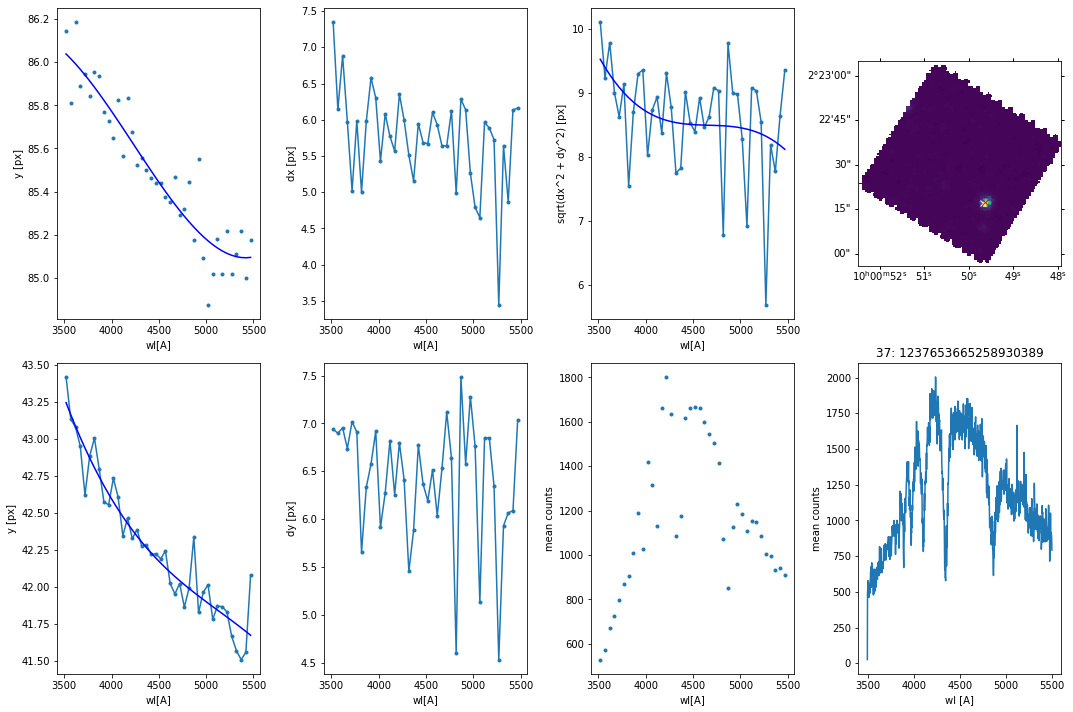

#############################################################
Extracting spectra from IFU 42 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_042_pca.fits.gz ...
#############################################################
#############################################################
Extracting spectra from IFU 43 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_043_pca.fits.gz ...
#############################################################
#############################################################
Extracting spectra from IFU 44 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_044_pca.fits.gz ...
#############################################################
###  1237653665258930548  ###
   Did not survive mag cut umag=21.93 gmag=21.91.
###  1237653665258930962  ###
   Did not survive mag cut umag=24.1 gmag=22.98.
#############################################################
Extracting spectra from IFU 45 /work/04287/mxhf/maverick/hetdex/cubes/data

    Wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997303856.txt.


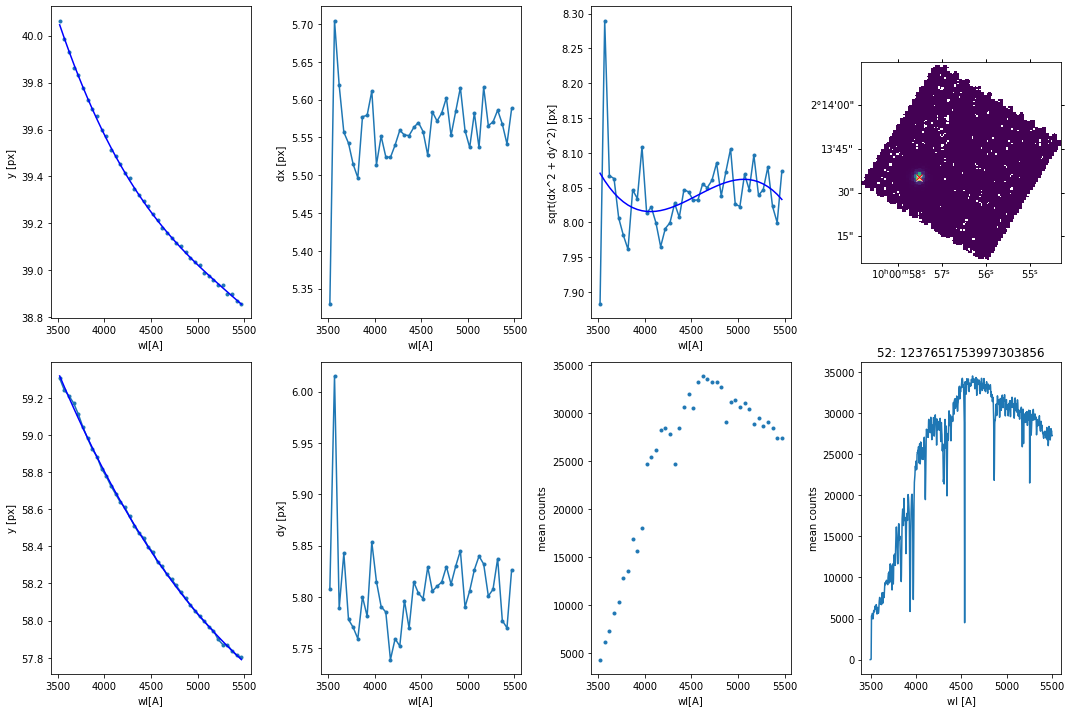

#############################################################
Extracting spectra from IFU 53 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_053_pca.fits.gz ...
#############################################################
###  1237651753997304005  ###
   Did not survive mag cut umag=23.07 gmag=20.53.
#############################################################
Extracting spectra from IFU 62 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_062_pca.fits.gz ...
#############################################################
###  1237651753997303937  ###
   Did not survive mag cut umag=22.25 gmag=19.63.
#############################################################
Extracting spectra from IFU 63 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_063_pca.fits.gz ...
#############################################################
###  1237651753997304213  ###
   Did not survive mag cut umag=23.53 gmag=22.1.
########################################################

/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


    Wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997238521.txt.


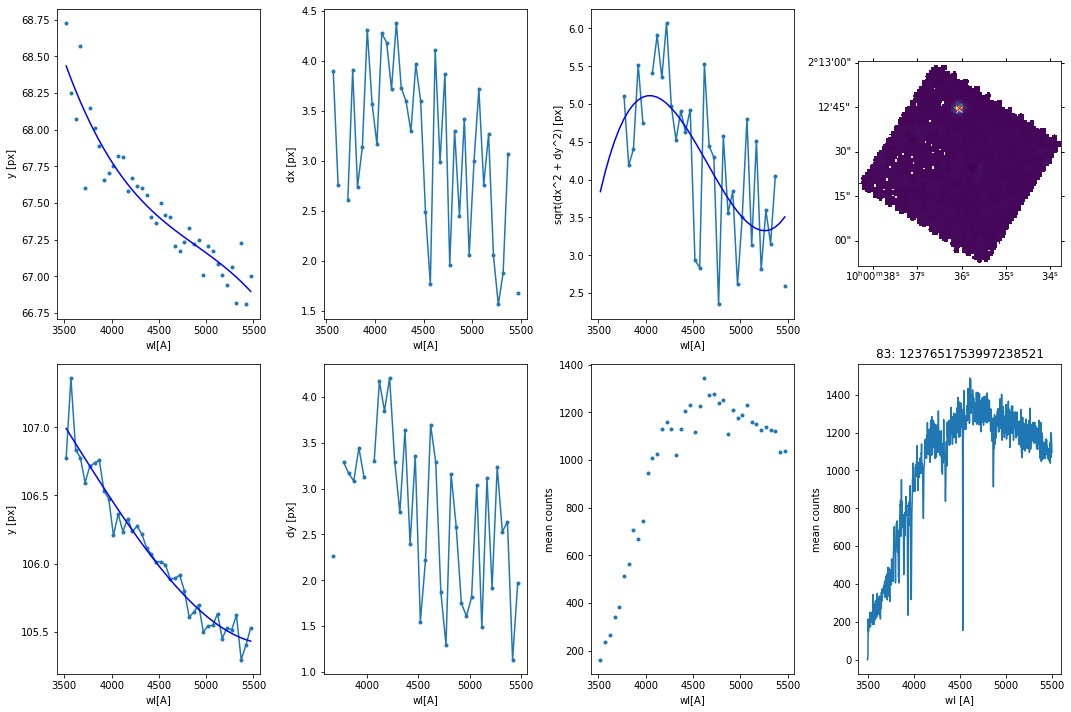

#############################################################
Extracting spectra from IFU 84 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_084_pca.fits.gz ...
#############################################################
###  1237651753997239000  ###
   Did not survive mag cut umag=23.34 gmag=22.24.
#############################################################
Extracting spectra from IFU 85 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_085_pca.fits.gz ...
#############################################################
###  1237651753997239188  ###
   Did not survive mag cut umag=24.91 gmag=23.35.
#############################################################
Extracting spectra from IFU 86 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_086_pca.fits.gz ...
#############################################################
###  1237653665258931038  ###
   Did not survive mag cut umag=25.24 gmag=23.85.
#######################################################

    Wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997238466.txt.


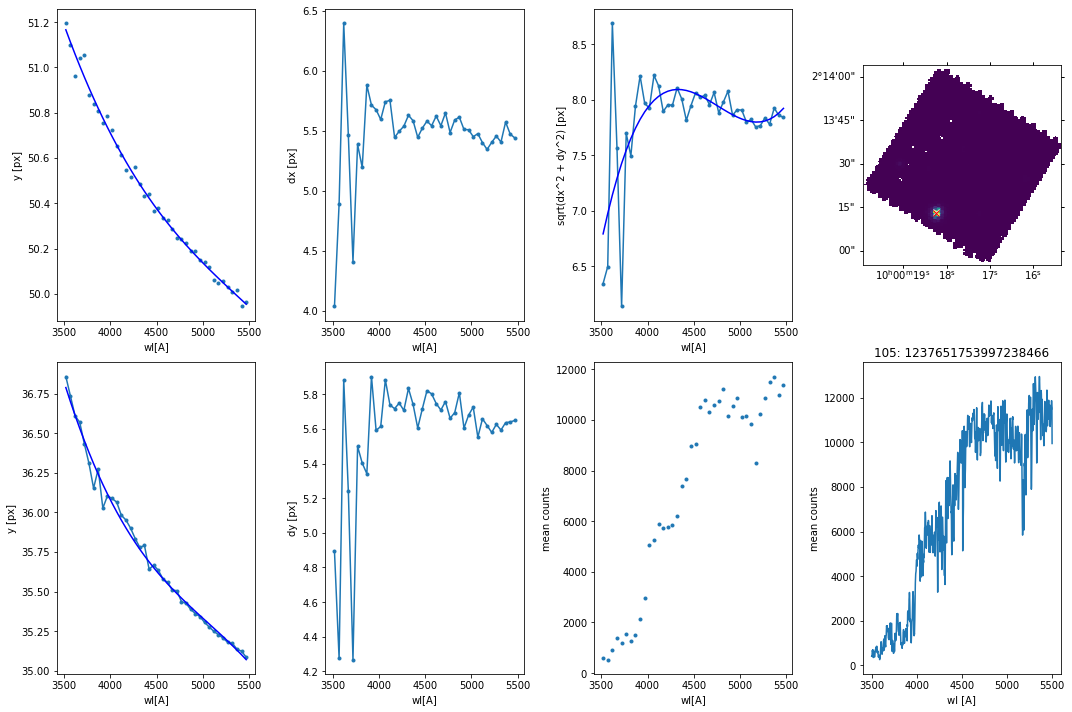

###  1237651753997238837  ###
   Did not survive mag cut umag=24.05 gmag=22.22.
###  1237651753997238853  ###
   Did not survive mag cut umag=23.41 gmag=21.21.
#############################################################
Extracting spectra from IFU 106 /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_106_pca.fits.gz ...
#############################################################
###  1237651753997238812  ###
   Did not survive mag cut umag=22.45 gmag=21.79.
###  1237651753997238817  ###
   Did not survive mag cut umag=25.71 gmag=22.26.


In [12]:
import os

all_adms = {}
all_spectra = {}

_ifu_list = ifu_list["col1"]
#_ifu_list = [74] # for testing
            
#_ifu_list = [83]
for ifu in _ifu_list:
    fcube = "{}/outcube_{}_{:03d}{}.fits.gz".format(datadir,field,ifu, suffix)

    print("#############################################################")
    print("Extracting spectra from IFU {} {} ...".format(ifu, fcube))
    print("#############################################################")
    t = ascii.read(fifustars)

    # read spectrum
    if not os.path.exists(fcube):
        print("File {} does not exist.".format(fcube))
        continue
    c = spectrum.readSpectrum(fcube)
    #mn = np.nanmedian( c.data, axis = 0 )

    t_inside = project(c,t) # find which stars fall inside the IFU cube footprint (not necessarily the IFU)
                            # also compute x,y coordinates

    spectra, adms = extract_all_in_ifu(c,t_inside, field, ifu, outdir)
    all_adms[ifu] = adms
    all_spectra[ifu] = spectra
    
    #break

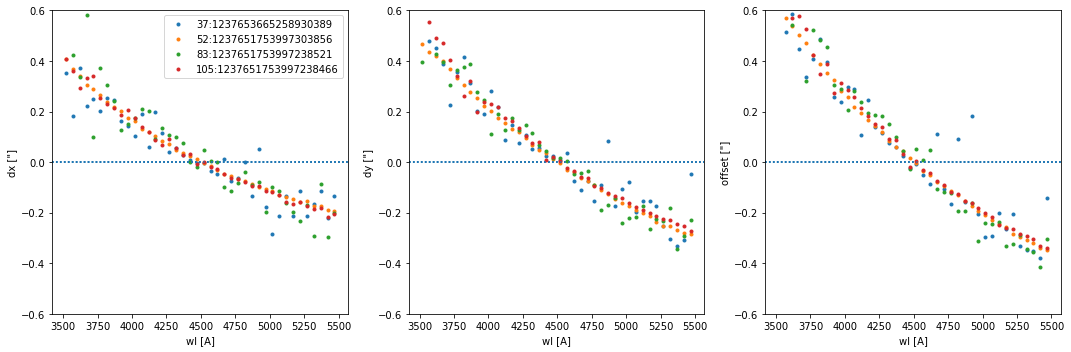

In [13]:
w = wcs.WCS(c.hdu.header)
w.dropaxis(2)
ps = np.abs(w.wcs_pix2world(0,0,0,0)[1] - w.wcs_pix2world(0,1,0,0)[1])*3600.

f = plt.figure(figsize=[15,5])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
for ifu in all_adms:
    for id in all_adms[ifu]:
        all_adms[ifu][id]
        ww = all_adms[ifu][id].centroids[:,0]
        xx = all_adms[ifu][id].centroids[:,2]
        yy = all_adms[ifu][id].centroids[:,3]
        mx = all_adms[ifu][id].xofw(4500.)
        my = all_adms[ifu][id].yofw(4500.)
        
        ax1.plot(ww,(xx-mx) * ps,'.', label="{}:{}".format(ifu,id))
        ax1.set_ylim([-.6,.6])
        ax1.set_xlabel("wl [A]")
        ax1.set_ylabel("dx [\"]")
        ax1.axhline(0.,ls=':')
        
        ax2.plot(ww,(yy-my) * ps,'.')
        ax2.set_ylim([-.6,.6])
        ax2.set_ylabel("dy [\"]")
        ax2.set_xlabel("wl [A]")
        ax2.axhline(0.,ls=':')
         
        ax3.plot(ww,np.sqrt((xx-mx)**2. +  (yy-my)**2.) * np.sign((xx-mx))* ps,'.')
        ax3.set_ylim([-.6,.6])
        ax3.set_ylabel("offset [\"]")
        ax3.set_xlabel("wl [A]")
        ax3.axhline(0.,ls=':')
        
ax1.legend()
f.tight_layout()

# Now compute calibration (= response curve)...

In [14]:
from astropy.io import ascii
import numpy as np
from astropy import table
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
def read_data(fspec, fsed):
    # read data
    spec = ascii.read(fspec, format='fixed_width')
    sed = ascii.read(fsed)
    sed = sed[1:]
    return spec, sed

In [16]:
def compute_cal(spec, sed, fsed, PLOT=True):
    dw = np.mean( np.diff(sed["col1"][1:]) )
    spec_binned = []
    for w in sed["col1"]:
        ii  = spec["wl"] >= w-dw/2.
        ii *= spec["wl"] <  w+dw/2.
        spec_binned.append( np.mean(spec["count"][ii]) )
    spec_binned = np.array(spec_binned)


    cal = sed["col2"]/spec_binned
    cal_interp = interp1d(sed["col1"], cal, kind='cubic', bounds_error=False)
    
    if PLOT:
        f = np.mean(cal)
        fig = plt.figure(figsize=[15,5])
        plt.title("Foo")

        plt.subplot(131)
        plt.plot(sed["col1"],sed["col2"],'x')
        plt.plot(spec["wl"],spec["count"]*f,'b-', alpha=.5)
        plt.plot(sed["col1"],spec_binned*f,'bo')
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")

        ax2 = plt.subplot(132)
        plt.plot(sed["col1"],cal,'s')
        plt.plot(sed["col1"],cal_interp(sed["col1"]),'k-')
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")
        plt.text(.5,1.05,fsed, transform=ax2.transAxes,ha='center',va='bottom')


        plt.subplot(133)
        plt.plot(sed["col1"],spec_binned*cal,'bo')
        plt.plot(sed["col1"],sed["col2"],'kx')
        plt.plot(spec["wl"],spec["count"]*cal_interp(spec["wl"]),'b-', alpha=.5)
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")
        fig.tight_layout()
        plt.show()
        
        return sed["col1"], cal, spec_binned


In [17]:
def do_cal(dirspecphot, field, sdss_id):
    fsed = "{}/seds/{}/000001_{}.txt".format(dirspecphot, field, sdss_id)
    fspec = "{}/extract/{}/{}.txt".format(dirspecphot, field, sdss_id)
    fcalout = "{}/extract/{}/{}_cal.txt".format(dirspecphot, field, sdss_id)

    # read data
    spec, sed = read_data(fspec, fsed)

    #compute calibration
    ww, cal, spec_binned = compute_cal(spec, sed, fsed)

    # write calibration
    tcal = table.Table(data=[ww, cal, spec_binned], dtype=[float,float, float], names=["wl[A]","cal[erg/s/cm^2/A/cnt]","counts"])
    tcal.write(fcalout, overwrite=True, format="ascii.fixed_width")
    print("Wrote {}".format(fcalout))
    

In [18]:
for ifu in all_spectra:
    for id in all_spectra[ifu]:
        !ls $dirspecphot/extract/$field/$id*

/work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237653665258930389_cal.txt
/work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237653665258930389.txt
/work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997303856_cal.txt
/work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997303856.txt
/work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997238521_cal.txt
/work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997238521.txt
/work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997238466_cal.txt
/work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997238466.txt


In [19]:
# manually flag bad objects (galaxies that were accidently labelled stars by sdss or bad extractions)
# COSMOSC
badids = [1237653665258995920, 1237651753997304229]

# COSMOSD
badids = [1237653665258995724, 1237653665258930230]

# GOODSN
#badids = [1237655464306475080, 1237655464306475099]

In [20]:
import glob

# Here we must select which stars we actually want to use for the claibration
cal_star_ids = []
for ifu in all_spectra:
    for sdss_id in all_spectra[ifu]:
            fs   = "{}/extract/{}/{}.txt".format(dirspecphot, field,sdss_id)
            ffs = glob.glob(fs)
            fsed = "{}/seds/{}/000001_{}.txt".format(dirspecphot, field,sdss_id)
            ffsed = glob.glob(fsed)
            #print(ffs)
            #print(ffsed)
            if len(ffs) == 1 and len(ffsed) == 1 and not sdss_id in badids:
                cal_star_ids.append(sdss_id) 

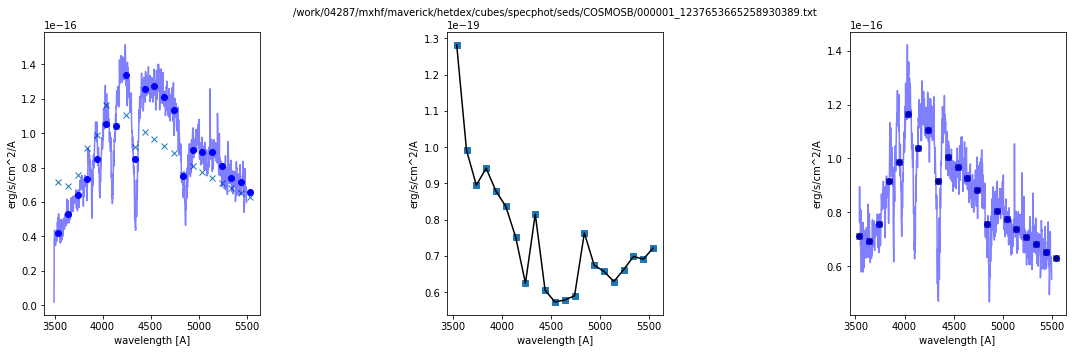

Wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237653665258930389_cal.txt


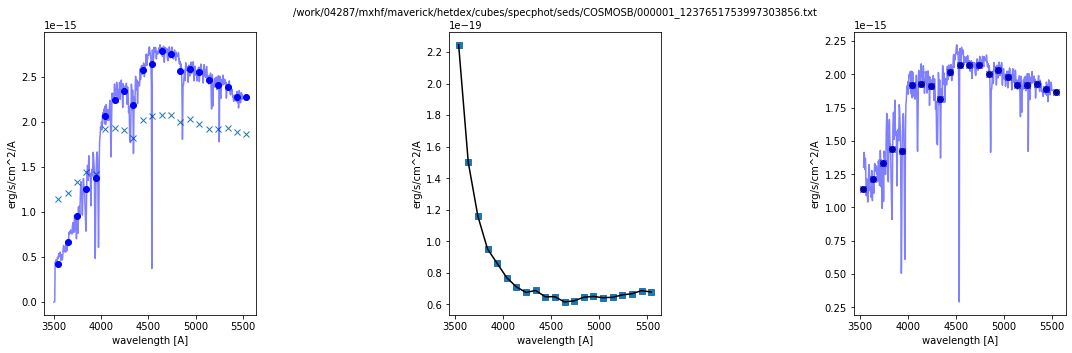

Wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997303856_cal.txt


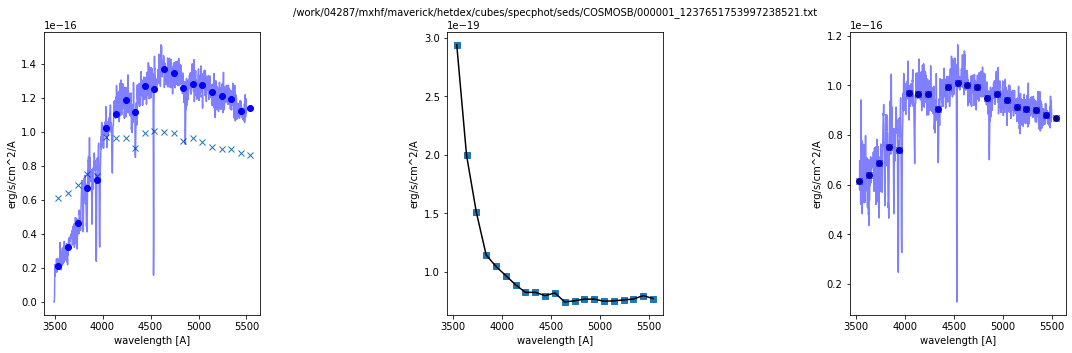

Wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997238521_cal.txt


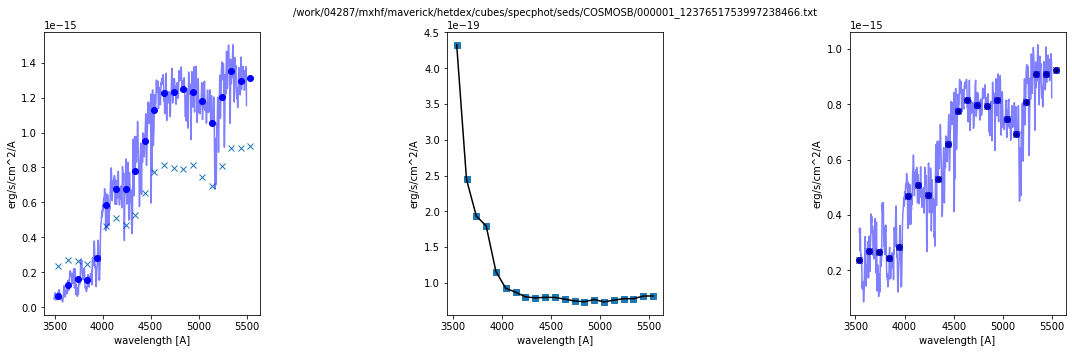

Wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/extract/COSMOSB/1237651753997238466_cal.txt


In [21]:
# run the clibration
for sdss_id in cal_star_ids:
    do_cal(dirspecphot, field, sdss_id)

[1.48472622 0.72674285 0.52144524 0.46739645 0.16434685 0.10272567
 0.10113675 0.11304338 0.07264872 0.11573309 0.1371375  0.10996838
 0.09746747 0.06582483 0.07120156 0.06208193 0.07966413 0.07307214
 0.0625516  0.07875612 0.07014367]


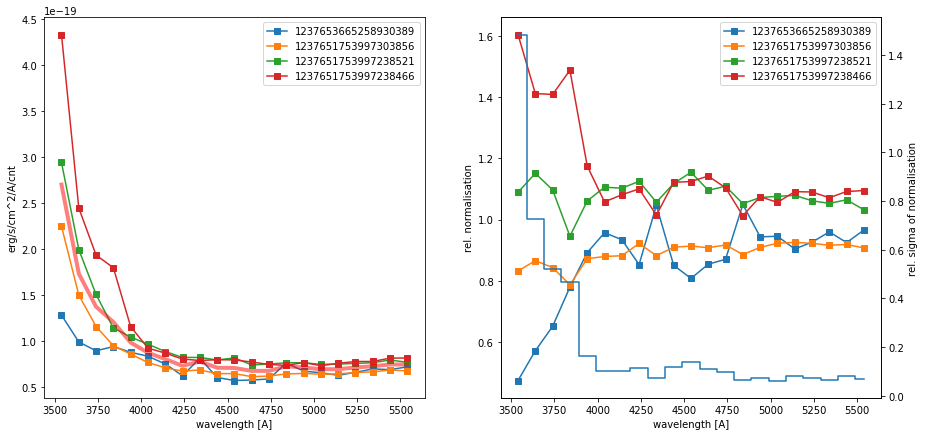

In [22]:
# Visualize the different response curves
# as well as their mean and their scatter
f = plt.figure(figsize=[15,7])

ax1 = plt.subplot(121)
all_cal = []
all_cnt = []
for cal_star_id in cal_star_ids:
    fcalout = "{}/extract/{}/{}_cal.txt".format(dirspecphot, field, cal_star_id)
    tcal = ascii.read(fcalout, format='fixed_width')
    all_cal.append(tcal['cal[erg/s/cm^2/A/cnt]'])
    all_cnt = [tcal['counts']]
    plt.plot(tcal['wl[A]'],tcal['cal[erg/s/cm^2/A/cnt]'],'s-', label=cal_star_id)
plt.legend()
plt.ylabel("erg/s/cm^2/A/cnt")
plt.xlabel("wavelength [A]")


ax2 = plt.subplot(122)
all_cal = np.array(all_cal)
all_cnt = np.array(all_cnt)
mall_cal = np.mean(all_cal, axis=0)

for cal_star_id in cal_star_ids:
    fcalout = "{}/extract/{}/{}_cal.txt".format(dirspecphot, field, cal_star_id)
    tcal = ascii.read(fcalout, format='fixed_width')
    plt.plot(tcal['wl[A]'],tcal['cal[erg/s/cm^2/A/cnt]']/mall_cal,'s-', label=cal_star_id)
plt.legend()
#plt.ylabel("erg/s/cm^2/cnt")
plt.xlabel("wavelength [A]")
plt.ylabel("rel. normalisation")
plt.twinx()

# compute average calibration
ss = []
mm = []
wmm = [] # weighted mean
ws = []
ww = tcal['wl[A]']
for i,w in enumerate(ww):
    s = np.std( all_cal[:,i] )
    m = np.mean( all_cal[:,i] )
    wm = np.mean( all_cal[:,i]*all_cnt[:,i] )/np.sum(all_cnt[:,i])
    #w = (wlmax+wlmin)/2.
    ss.append(s)
    ws.append(w)
    mm.append(m)
    wmm.append(wm) # form weighted mean
plt.plot(ww,ss/m,drawstyle='steps-mid')
plt.ylabel("rel. sigma of normalisation")

ax1.plot(ww,wmm,'r-', lw=4, alpha=.5)


print(ss/m)

In [23]:
# save the computed mean calibration
tmeancal = table.Table(data=[ww, mm], names=['wl[A]','cal[erg/s/cm^2/A/cnt]'], dtype=[float,float])
tmeancal.write("{}/mean_cal_{}.txt".format(dirspecphot, field), format='ascii.fixed_width')
print("wrote {}/mean_cal_{}.txt".format(dirspecphot, field))

wrote /work/04287/mxhf/maverick/hetdex/cubes/specphot/mean_cal_COSMOSB.txt


# check that application of flux calibration to cube worked well

In [24]:
def apply_cal(fcubein, ftcal, fcubeout):
    print("Applying calibration to {}...".format(fcubein) )

    tcal = ascii.read(ftcal, format="fixed_width")

    cal_interp = interp1d(tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"], kind='cubic', bounds_error=False,fill_value="extrapolate")

    s = spectrum.readSpectrum(fcubein)

    ww = s.grid()
    for i,w in enumerate(ww):
        s.data[i] = s.data[i] * cal_interp(w) #* 1e17

    h = fits.PrimaryHDU(data=s.data, header=s.hdu.header)
    #h.header['BUNITS'] = 'erg'
    h.writeto(fcubeout, overwrite=True)

In [25]:
# all we do is to muyltiply each pixel with the response curve
import spectrum
from scipy.interpolate import interp1d
from astropy.io import ascii, fits


for ifu in all_spectra:
    for sdss_id in all_spectra[ifu]:
        if sdss_id in cal_star_ids:
            
            fcubein = "{}/outcube_{}_{:03d}{}.fits.gz".format(datadir, field, ifu, suffix)
            ftcal = "{}/mean_cal_{}.txt".format(dirspecphot, field)
            fcubeout = "{}/coutcube_{}_{:03d}{}.fits.gz".format(datadir, field, ifu, suffix)
            
            apply_cal(fcubein, ftcal, fcubeout)

Applying calibration to /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_037_pca.fits.gz...
Applying calibration to /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_052_pca.fits.gz...
Applying calibration to /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_083_pca.fits.gz...
Applying calibration to /work/04287/mxhf/maverick/hetdex/cubes/data/outcube_COSMOSB_105_pca.fits.gz...


In [26]:
!ls /work/04287/mxhf/maverick/hetdex/cubes/data/cou*

/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSA_036_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSA_044_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSA_073_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSA_074_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSB_037_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSB_052_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSB_083_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSB_105_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSC_026_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSC_033_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSC_072_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSC_073_pca.fits.gz
/work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSC_084_pca.fits.gz

In [27]:
!ls /work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSC_026.fits.gz

ls: cannot access /work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSC_026.fits.gz: No such file or directory


Extracting spectra from IFU 037 /work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSB_037_pca.fits.gz ...
###  1237653665258930389  ###
   Did survive mag cut umag=19.53 gmag=19.31.
is_star: sdss_id =  1237653665258930389
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237653665258930389
   OK 1237653665258930389 is a star.
   M = 0.0
   x_com = 85.52438843185786, y_com = 42.280980880328286
   Distance of 1237653665258930389 to next zero pixel ok with 22.5.
   Mean counts of 1237653665258930389 with 1.0054734629604196e-16 cts is sufficient to continue.


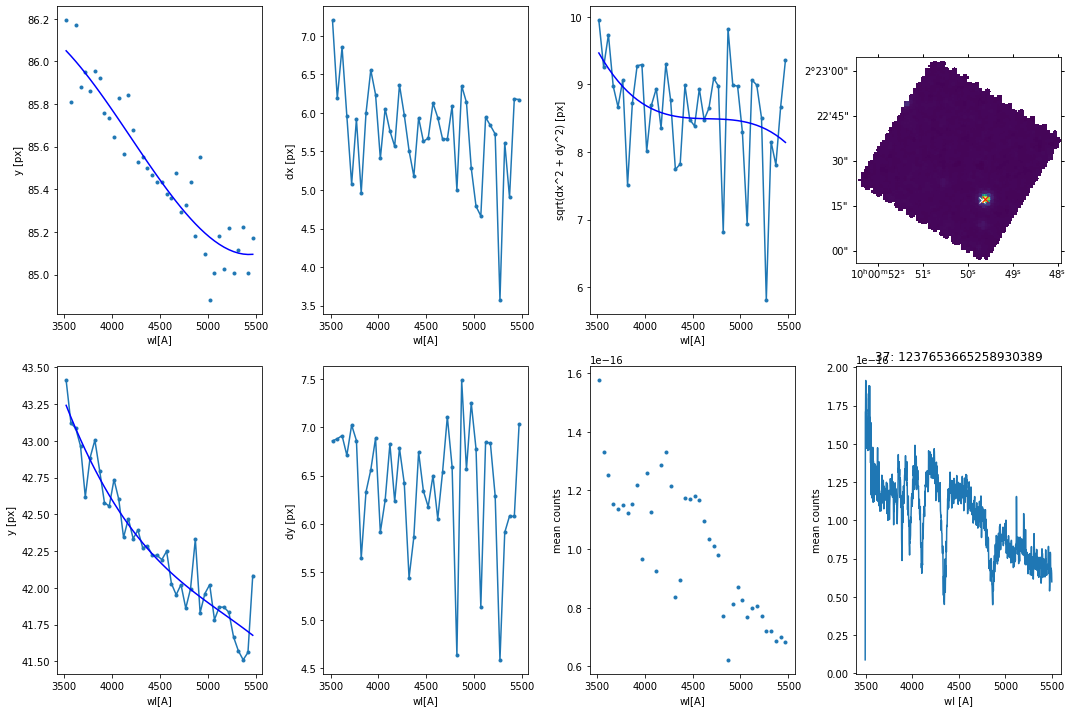

Extracting spectra from IFU 052 /work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSB_052_pca.fits.gz ...
###  1237651753997303856  ###
   Did survive mag cut umag=17.01 gmag=15.92.
is_star: sdss_id =  1237651753997303856
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237651753997303856
   OK 1237651753997303856 is a star.
   M = 0.0
   x_com = 39.23286607157241, y_com = 58.3163165888844
   Distance of 1237651753997303856 to next zero pixel ok with 16.6.
   Mean counts of 1237651753997303856 with 2.0106601847481697e-15 cts is sufficient to continue.


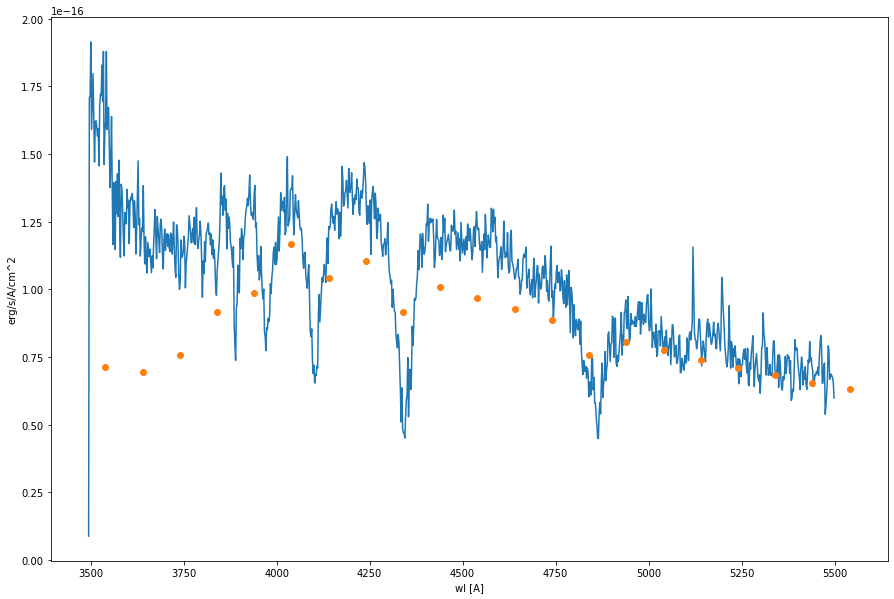

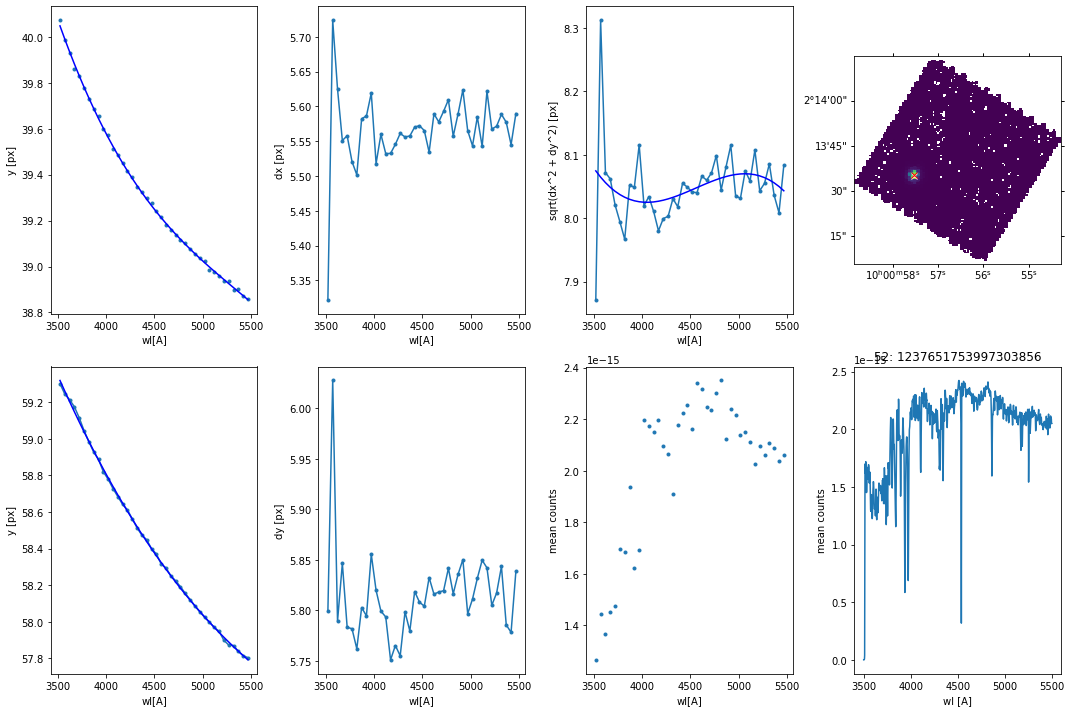

Extracting spectra from IFU 083 /work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSB_083_pca.fits.gz ...
###  1237651753997238521  ###
   Did survive mag cut umag=20.12 gmag=19.21.
is_star: sdss_id =  1237651753997238521
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237651753997238521
   OK 1237651753997238521 is a star.
   M = 0.0
   x_com = 67.46796548154944, y_com = 106.0133536350616
   Distance of 1237651753997238521 to next zero pixel ok with 10.9.
   Mean counts of 1237651753997238521 with 7.802750775952624e-17 cts is sufficient to continue.


/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


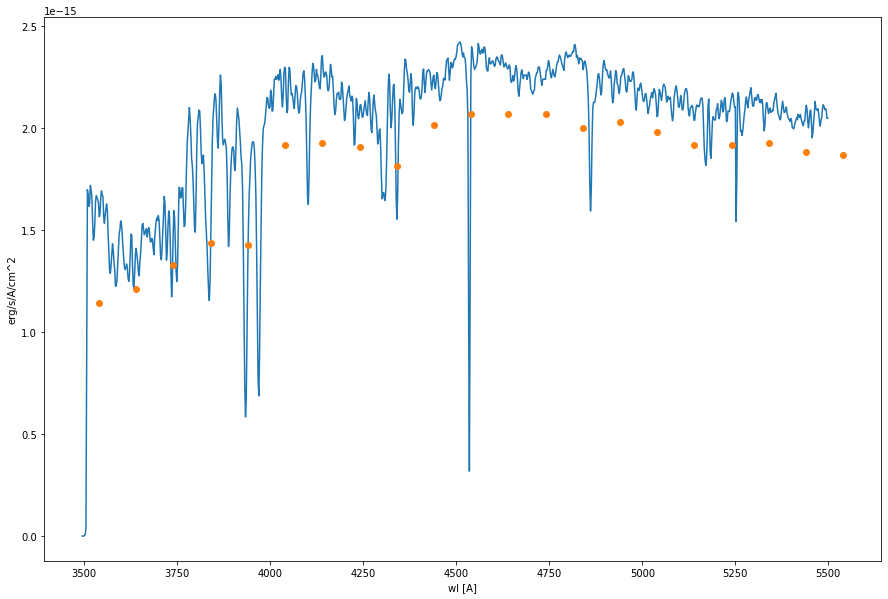

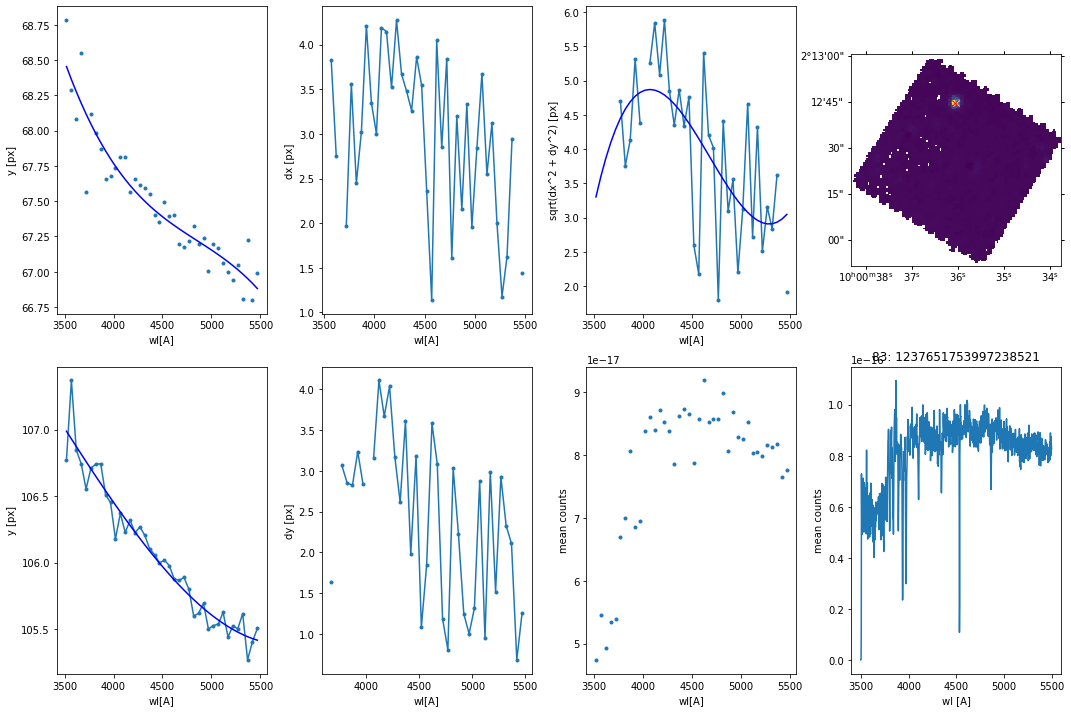

Extracting spectra from IFU 105 /work/04287/mxhf/maverick/hetdex/cubes/data/coutcube_COSMOSB_105_pca.fits.gz ...
###  1237651753997238466  ###
   Did survive mag cut umag=19.2 gmag=17.02.
is_star: sdss_id =  1237651753997238466
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237651753997238466
   OK 1237651753997238466 is a star.
   M = 0.0
   x_com = 50.296534716447574, y_com = 35.51594563326113
   Distance of 1237651753997238466 to next zero pixel ok with 12.0.
   Mean counts of 1237651753997238466 with 5.43112432035089e-16 cts is sufficient to continue.


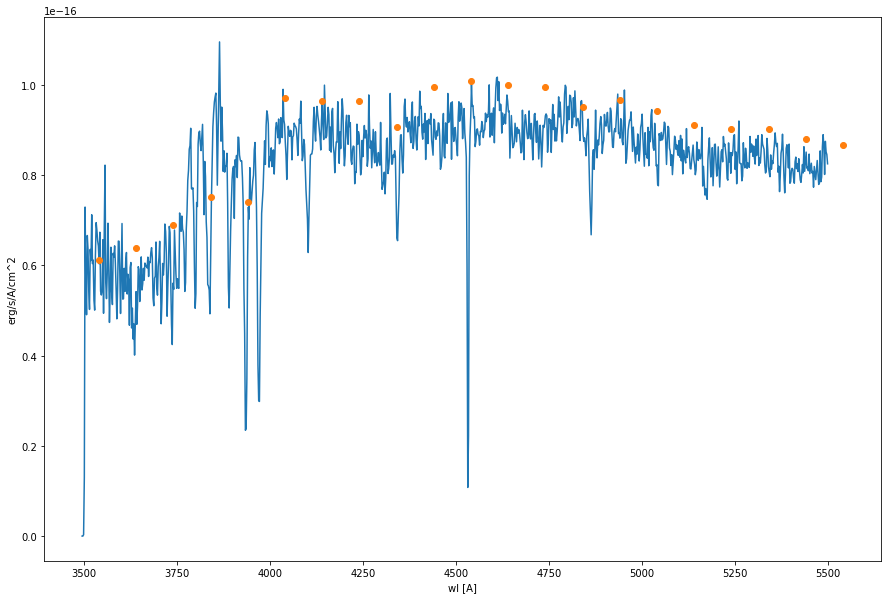

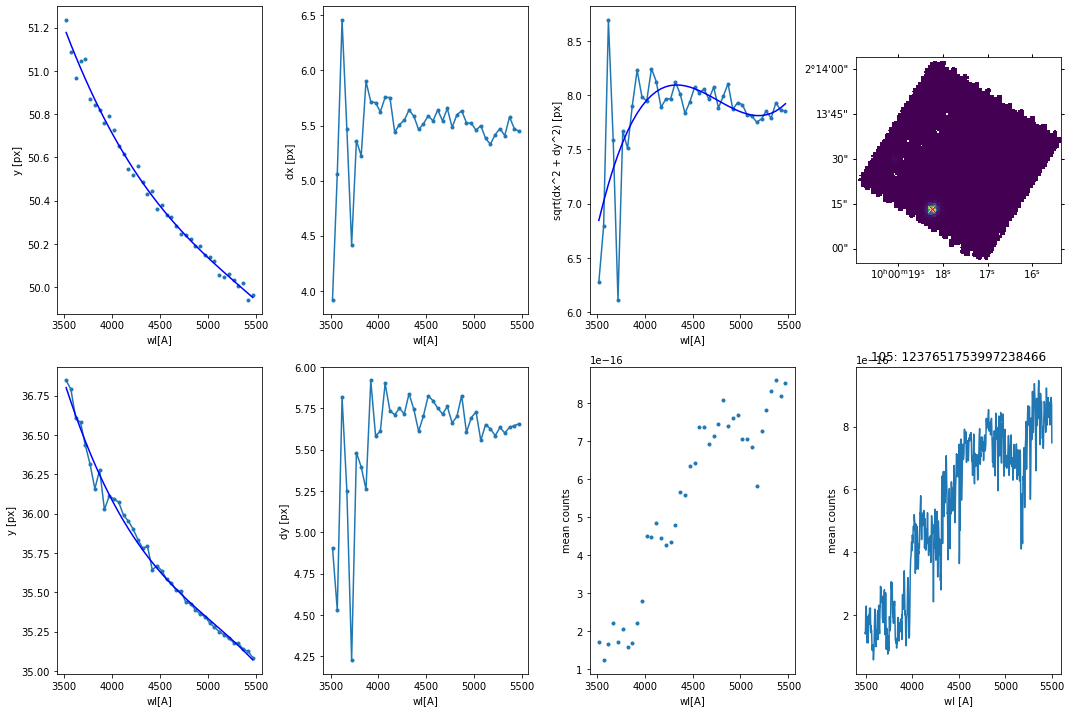

###  1237651753997238837  ###
   Did not survive mag cut umag=24.05 gmag=22.22.
###  1237651753997238853  ###
   Did not survive mag cut umag=23.41 gmag=21.21.


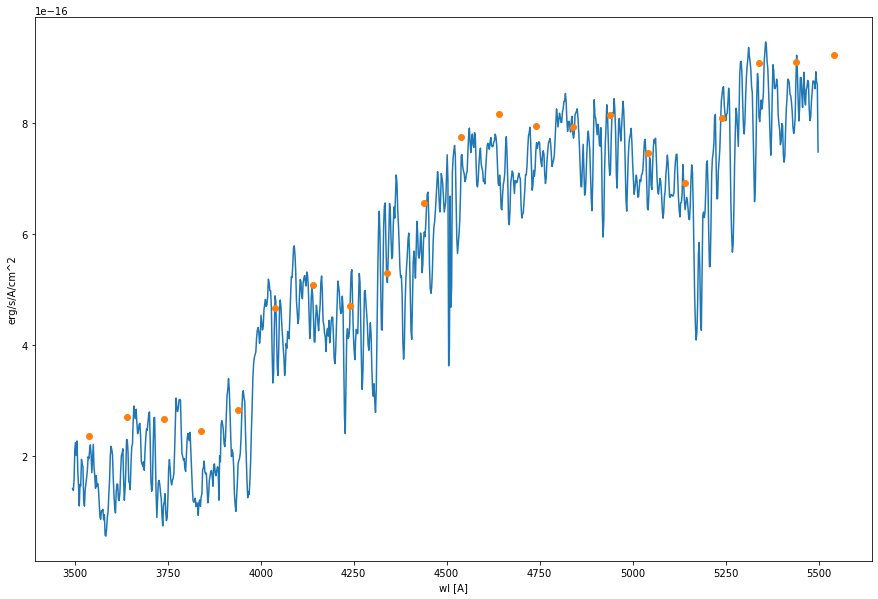

In [28]:
# here we extract spectra for the calibration stars
# and overplot the SEDs
for ifu in all_spectra:
    for sdss_id in all_spectra[ifu]:
        if sdss_id in cal_star_ids:
            fcube = "{}/coutcube_{}_{:03d}{}.fits.gz".format(datadir, field, ifu, suffix)

            print("Extracting spectra from IFU {:03d} {} ...".format(ifu, fcube))
            t = ascii.read(fifustars)

            # read spectrum
            c = spectrum.readSpectrum(fcube)
            

            t_inside = project(c, t)
            #ii = t_inside["col2"] == str(star_id)


            spectra, adms = extract_all_in_ifu(c, t_inside, field, ifu, outdir, threshold=0.,SAVESPEC=False)

            
            # and plot the spectra
            ww,ff  = spectra[sdss_id]

            fsed = "{}/seds/{}/000001_{}.txt".format(dirspecphot,field,sdss_id)
            sed = ascii.read(fsed)
            sed = sed[1:]


            f = plt.figure(figsize=[15,10])
            ax2 = plt.subplot()

            plt.plot( ww,ff  ,'-')
            plt.plot( sed["col1"], sed["col2"] ,'o')

            ax2.set_xlabel("wl [A]")
            ax2.set_ylabel("erg/s/A/cm^2")

In [29]:
1/0

ZeroDivisionError: division by zero

# For COSMOSA now take the one actually existing SDSS spectrum 3154-54821-0160

In [ ]:
ifu = 73

fcubein = "{}/outcube_{}_{:03d}{}.fits.gz".format(datadir, field, ifu, suffix)
ftcal = "{}/mean_cal_{}.txt".format(dirspecphot, field)
fcubeout = "{}/coutcube_{}_{:03d}{}.fits.gz".format(datadir, field, ifu, suffix)

apply_cal(fcubein, ftcal, fcubeout)

In [ ]:
!ls $datadir/outcube_COSMOSC_073$suffix.fits.gz

In [ ]:

fcube = "{}/coutcube_{}_{:03d}{}.fits.gz".format(datadir, field, ifu, suffix)


print("Extracting spectra from IFU {} {} ...".format(ifu, fcube))

# read spectrum
c = spectrum.readSpectrum(fcube)
xx,yy = np.arange(c.data.shape[2]), np.arange(c.data.shape[1])
XX,YY = np.meshgrid(xx,yy)

# take median collapsed cube a slice
sl = np.nanmedian( c.data, axis = 0 )
spectra = {}

xc = 59.230769
yc = 125.0863

# take initial values for position 
dd = np.sqrt( (XX-xc)**2. + (YY-yc)**2. )

jj = dd < 10.

# compute moments
M = np.nansum(sl[jj])
x_com = np.nansum(sl[jj]*XX[jj])/M
y_com = np.nansum(sl[jj]*YY[jj])/M

dx = np.sqrt( np.nansum( sl[jj] * (XX[jj] - x_com)**2. ) / M ) * 2.35 # FWHM
dy = np.sqrt( np.nansum( sl[jj] * (YY[jj] - y_com)**2. ) / M ) * 2.35 # FWHM
size = np.sqrt(dx**2. + dy**2.)
#print("   ", r['col2'], r["col3"], r["col4"], r['x'], r['y'], x_com, y_com, dx, dy, size )

# recompute
dd2 = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. ) 

# I *think* this is essentially a Kron aperture
#kk = dd2 <= 2. * size
# Make it larger to get more
#kk = dd2 <= 3. * size
kk = dd2 <= 1. * size

#ww,ss =  extract(c,kk)

ww, ss =  extract(c, x_com, y_com, size, XX, YY, apfactor=3.)

In [ ]:
from astropy.table import Table

sdss = Table.read("{}/spec-3154-54821-0160.fits".format(dirspecphot))

In [ ]:
import numpy as np
f = plt.figure(figsize=[15,10])
plt.plot(ww,ss, label='HETDEX')

plt.plot( 10.**( sdss['loglam'] ), sdss['flux']*1e-17, label='sdss', alpha=.5)

plt.xlim([3750.,5600.])

plt.ylabel("flux [erg/s/cm^2/A]")
plt.xlabel("wavelength [A]")

# compare calibrations

In [ ]:
fcals = !ls ../specphot/mean_cal*

In [ ]:
fig = plt.figure(figsize=[10,7])
for f in fcals:
    print(f)
    tcal = ascii.read(f, format="fixed_width")
    plt.plot( tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"] ,'o-', label=f)
 

plt.ylabel("spectral response\n [erg/s/cm^2/A/count]")
plt.xlabel("wavelength [A]")
plt.legend()
fig.tight_layout()